<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Anomaly Detection in Network Data using GANs

Welcome to the third lab of this series!

In the previous labs, we tried our hand at supervised and unsupervised anomaly detection using XGBoost and Deep Autoencoders on the KDD-99 network intrusion dataset.

We addressed the issue of unlabelled training data through the use of Deep Autoencoders in the second lab. However, unsupervised methods such as PCA and Autoencoders tend to be effective only on highly correlated data such as the KDD dataset, and these algorithms might also require the data to follow a Gaussian Distribution.

> "Adversarial training (also called GAN for Generative Adversarial Networks), and the variations that are now being proposed, is the most interesting idea in the last 10 years in ML, in my opinion.".
> Yann LeCun, 2016.

What do GANs bring to the table and how are they different from Deep Autoencoders?

GANs are generative models that generate samples similar to the training dataset by learning the true data distribution. So instead of compressing the input into a latent space and classifying the test samples based on the reconstruction error, we actually train a classifier that outputs a probability score of a sample being Normal or Anomalous. As we will see later in the lab, this has positioned GANs as very attaractive unsupervised learning techniques.

GANs can be pretty tough to train and improving their stability is an active area of research today.

In [1]:
# Import system packages
import os
import sys
import time
import logging
import importlib

#Import data manipulation libraries
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm

#Import visualization libraries
import matplotlib.pyplot as plt

#Importing ML/DL libraries
from sklearn.preprocessing import MinMaxScaler, label
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layer

from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
import pickle

import random
random.seed(123)

data_path = './data/'

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)


## Section 1: Dataset

Let us load the same KDD-99 dataset that we used in the previous labs. 

In [2]:
#loading the pickled file

filename = data_path + 'preprocessed_data_full.pkl'
input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.0 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Just like in Lab 2, we will split the pickled data into vectors and assign them to the label encoder `le`, training and testing sets.

In [3]:
for key in preprocessed_data:
    print(key)  

x_train
y_train
x_test
le
y_test


In [4]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [5]:
np.unique(y_train)

array([ 0,  5,  9, 10, 11, 15, 17, 18, 20, 21])

### 1.1 Data Preprocessing

We first consider the binary classification problem. Similar to previous labs, *Normal* data points will be labeled as '0' and *Anomalous* points will be labeled as '1'.

In [6]:
#Obtain the class number for Normal entries 
pd.DataFrame(le.classes_, columns = ['Type'])

,Type
0,back.
1,buffer_overflow.
2,ftp_write.
3,guess_passwd.
4,imap.
5,ipsweep.
6,land.
7,loadmodule.
8,multihop.
9,neptune.


In [7]:
# Converting labels to Binary

y_test[y_test != 11] = 1 
y_test[y_test == 11] = 0
y_train[y_train != 11] = 1
y_train[y_train == 11] = 0

We will now split the dataset into normal and anomalous data. We will need to do this in order to be able to train GANs to generate Normal packets only and then predict the anomaly based on the Discriminator output. The details regarding this will be covered later in the lab.

In [8]:
#Subsetting only Normal Network packets in our training set

temp_df = x_train.copy()
temp_df['label'] = y_train
temp_df = temp_df.loc[temp_df['label'] == 0]
temp_df = temp_df.drop('label', axis = 1)
x_train = temp_df.copy()

Similar to Lab 2, we scale the input training data between 0 and 1 before feeding it to the model.

In [9]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#Creating dataset dictionary 
dataset = {}
dataset['x_train'] = x_train.astype(np.float32)
dataset['y_train'] = y_train.astype(np.float32)
dataset['x_test']  = x_test.astype(np.float32)
dataset['y_test']  = y_test.astype(np.float32)

**Summary of the datasets** :
- The Training set consists of only normal network packets.
- The Testing set comprises a small number of anomalous network packets of about 1%, reflecting what we see in the real world. 


In [10]:
# check how many anomalies are in our Testing set
print('Number of Normal Network packets in the Training set:', x_train.shape[0])
print('Number of Normal Network packets in the Testing set:', collections.Counter(y_test)[0])
print('Number of Anomalous Network packets in the Testing set:', collections.Counter(y_test)[1])

Number of Normal Network packets in the Training set: 729620
Number of Normal Network packets in the Testing set: 243161
Number of Anomalous Network packets in the Testing set: 2466


## Section 2: Generative Adversarial Networks

Generative Adversarial Networks (GAN) were introduced by Ian Goodfellow in [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661), Goodfellow, 2014.

<br>
<img src="https://drive.google.com/uc?id=14f7ZwXxyigpwx7bIVFxAOSb_aV28bFav" alt="Alt text that describes the graphic" title="Title text" />
<br>


The GAN consists of two networks namely: 
- The generator `G` that produces fake samples
- The discriminator `D` that that receives samples from both `G` and the dataset.

During Training the two networks have competing goals. The generator tries to fool the discriminator by outputting values that resemble real data and the discriminator tries to become better at distinguishing between the real and fake data.

Mathematically, this means that the Generator's weights are optimized to maximize the probability that fake data is classified as belonging to the real data. The discriminators's weights are optimized to maximize the probability that the real input data is classified as real while minimizing the probability of fake input data being classified as real.

Optimality is reached when the generator produces an output that the disciminator cannot concretely label as real or fake and this, happens when either of the networks cannot improve anymore.

<img src=./images/gan-optimality.PNG alt="Alt text that describes the graphic" title="Title text" />

The first part of the above equation reflects the log probability of the discriminator predicting that the input sample is genuine and the second half reflects the probability of the Discriminator predicting that the Generator's output is not genuine.

In this lab, we will be train our GAN on normal network packets. The generator inputs noise and as training progresses the GAN learns the mapping between these random values to the input distribution. The discriminator outputs a score of how likely the the generated output resembles the real data.

### 2.1 Generator Network 

The Generator is used to synthesize fake data points. As shown below, it consists of 5 Dense Layers with a `tanh` activation function and uses `binary cross-entropy` for calculating the generator loss. Binary cross-entropy loss measures the performance of a two class classification model whose output is a probability value between 0 and 1. A perfect model would have a loss of 0.

![layers](images/layers.png)

In [11]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=114, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(114, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

### 2.2 Discriminator Network

![layers2](images/layers2.png)

The Discriminator basically outputs the score of a sample belonging to the real dataset or the synthetic dataset. It consists of 6 dense layers-each followed by a dropout layer to help prevent overfitting. The sigmoid activation function is applied to the final layer to obtain a value in the range 0 to 1.

In [12]:
##### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=114, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator

### 2.3 Building the Network

Previously we built the individual networks that constitute the GAN. Let us now stich them together by using the generator and discriminator as individual layers of the overall generative adversarial network. We set the field `discriminator.trainable = False` as we want to alter the weights of only one of them during training.

In [13]:
def get_gan_network(discriminator, generator, optimizer,input_dim=114):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

### 2.4 Setting the Hyperparameters 

Training a GAN can be quite tricky and time consuming. Refer to this <a href="https://github.com/soumith/ganhacks#authors">  link </a> to get a few ideas on how you could get your models to converge faster by choosing appropriate hyperparameters.

In [14]:
learning_rate = 0.00001
batch_size = 512
epochs = 10
adam = Adam(learning_rate = learning_rate,beta_1 = 0.5)

### 2.5 Training the Model

The generator first predicts on a batch of noise samples. As the generator has randomly initialized weights initially, the output of the generator at this stage is nothing but meaningless values.
<br>
<img src=./images/Gan-Page-04.jpg alt="Alt text that describes the graphic" title="Title text" />
<br>
The Discriminator inputs a stack of samples - the first half of which is the output of the generator and the second half is a batch of data samples from the real dataset. We train the Discriminator on this stack with the target labels  0 (Fake) for half the stack and 1 for the second half of the stack. The result of this is that the Discrimator is able to distinguish between the Real and Fake samples.
<br>
<img src=./images/Gan-Page-2.jpg alt="Alt text that describes the graphic" title="Title text" />
<br>
The weights of the discriminator are frozen by setting the trainable parameter to False.

To train the Generator, We first feed it random noise and let the entire GAN output a probability with the Discriminator weights remaining frozen. As expected this value would be less than 0.5 since the Discriminator was previously set to output a value close to 0 if the input was not genuine .
<br>
<img src=./images/Gan-Page-3.jpg alt="Alt text that describes the graphic" title="Title text" />
<br>

Now comes the trick. We tell the GAN that the expected output is 1. This results in the errors being backpropagated only to the Generator. With every sample in the batch the generator's weights are tuned such that the output of the GAN is close to 1, meaning the Generator is now learning to produce samples that resemble the real data.

This process loops back to the first step for each batch in the training set.

In [15]:
#Training the GAN
x_train, y_train, x_test, y_test = dataset['x_train'], dataset['y_train'],dataset['x_test'],dataset['y_test']

#Calculating the number of batches based on the batch size
batch_count = x_train.shape[0] // batch_size
pbar = tqdm(total=epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=114)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,114])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = x_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, 114])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))
              

 10%|█         | 1433/14250 [00:30<04:12, 50.69it/s]

Epoch 0 Batch 1424/1425 [D loss: 0.079249] [G loss:0.022202]


 20%|██        | 2857/14250 [00:59<03:46, 50.36it/s]

Epoch 1 Batch 1424/1425 [D loss: 0.041643] [G loss:0.003831]


 30%|███       | 4281/14250 [01:27<03:18, 50.33it/s]

Epoch 2 Batch 1424/1425 [D loss: 0.013771] [G loss:0.001141]


 40%|████      | 5709/14250 [01:56<02:53, 49.17it/s]

Epoch 3 Batch 1424/1425 [D loss: 0.011792] [G loss:0.000369]


 50%|█████     | 7131/14250 [02:25<02:25, 49.09it/s]

Epoch 4 Batch 1424/1425 [D loss: 0.009301] [G loss:0.001847]


 60%|██████    | 8555/14250 [02:55<01:53, 50.00it/s]

Epoch 5 Batch 1424/1425 [D loss: 0.014050] [G loss:0.000502]


 70%|███████   | 9984/14250 [03:24<01:27, 48.91it/s]

Epoch 6 Batch 1424/1425 [D loss: 0.035744] [G loss:0.001038]


 80%|████████  | 11408/14250 [03:52<00:57, 49.60it/s]

Epoch 7 Batch 1424/1425 [D loss: 0.001621] [G loss:0.000204]


 90%|█████████ | 12833/14250 [04:21<00:29, 48.86it/s]

Epoch 8 Batch 1424/1425 [D loss: 0.003099] [G loss:0.000154]


100%|█████████▉| 14248/14250 [04:50<00:00, 49.42it/s]

Epoch 9 Batch 1424/1425 [D loss: 0.010676] [G loss:0.000926]


### 2.6 Training Loss

Let's visualize the generator and discriminator training losses!

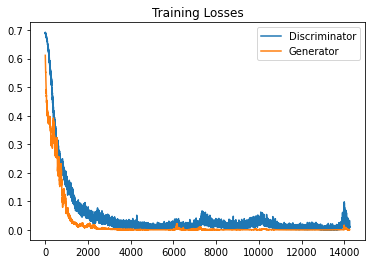

In [16]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

The loss convergence towards the end signifies that the GAN model has reached optimality

### 2.7 Anomaly Detection

What was the result of all the training we did?  

We now have a generator that can input a random seed value and produce an output that closely resembles the data it was trained on. You can read about how this strategy was used to come up with imaginary celebrities <a href ="https://research.nvidia.com/publication/2017-10_Progressive-Growing-of" >here</a>

The Discriminator that we trained ended up being a very powerful classifier that can tell if a sample point is representative of the true data distribution it was trained on or not and hence can be used for Anomaly Detection!

Let us feed our test data into the discriminator and obtain scores.

In [17]:
# Predictions on the test set

nr_batches_test = np.ceil(x_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = x_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

Let us calculate the mean score for normal and anomalous samples in our test set. Ideally, we would like to see a score close to 1 for normal samples and 0 for anomalous samples. This would mean our classifier is doing well in distinguishing between the 2 classes.  

In [18]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y_test)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for normal packets :', results_df.loc[results_df['y_test'] == 0, 'results'].mean() )
print ('Mean score for anomalous packets :', results_df.loc[results_df['y_test'] == 1, 'results'].mean())

Mean score for normal packets : 0.9962806252026298
Mean score for anomalous packets : 0.0278063134071834


But how exaclty do we identify our Anomalies?

Although there are several ways to do this, let us use a more straight forward way for detection. Remember 1% of our test set comprised of anomalies. So, the lowest 1% of the scores should ideally constitute anomalies. Let us test our hypothesis below.

In [19]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1


## Section 3: Evaluation

The Accuracy, Precision and Recall values of our model on the test set are as follows:

In [20]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.9988397041041905
Precision : 0.9438339438339438
Recall : 0.940389294403893
F1 : 0.9421084704448507


### 3.1 Confusion Matrix

The confusion matrix is a good way to understand if our predictions agree with the target labels. You've implemented one of these in both of the previous labs, so in this section, you'll get a chance to build your own. 

Confusion Matrix :


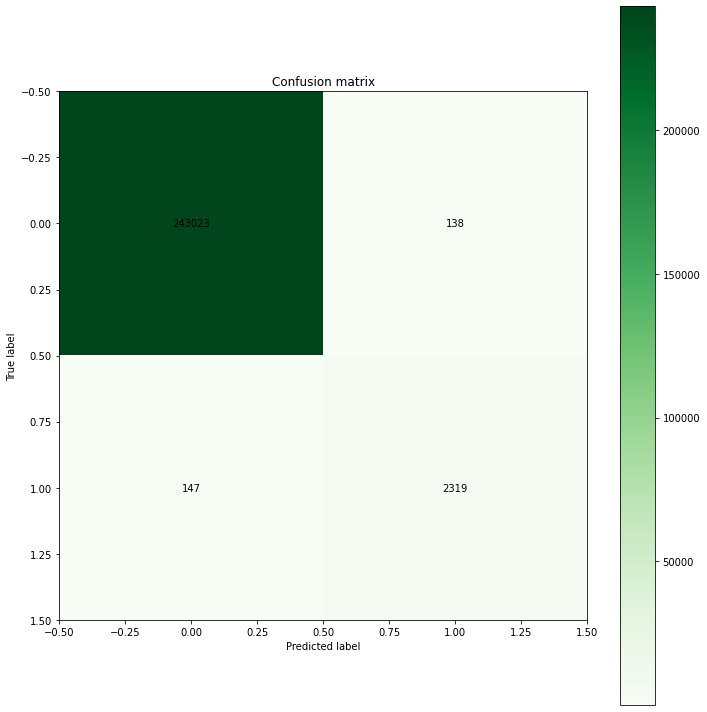

In [21]:
cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

### 3.2 ROC Curve

Let's see how our ROC curve looks with the predictions. The closer the AUC is to 1, the better the model.

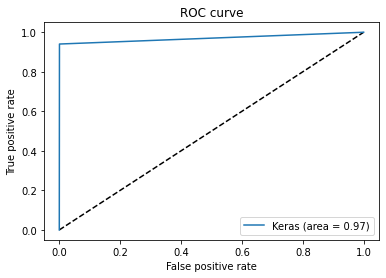

100%|██████████| 14250/14250 [05:10<00:00, 49.42it/s]

In [22]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Conclusion

- We successfully employed state of the art Generative Adversarial Networks for anomaly detection on high dimensional data such as the KDD dataset.
- The GAN is particularly interesting  because it sets up a supervised learning problem in order to do unsupervised learning. While it generates fake data, and tries to determine if a sample is fake or real based on trivial labels, it really does not know what the different classes in the dataset are.
- On the downside, GANs can be tough to train and suffer from convergence issues particularly because, the discriminator during training does not learn as much from the true dataset as it learns to distinguish between the probability distributions.

Take a moment to consider how each of the three methods actually detected anomalies. If time, take a moment to attempt to articulate each to a partner or write in a notebook or the space below. Bonus. Reflect on how each responded to the rarity of anomalies and why.

## References

<ol>
<li>Zenati, H., Foo, C., Lecouat, B., Manek, G. and Chandrasekhar, V. (2018). Efficient GAN-Based Anomaly Detection. [online]   Arxiv.org. Available at: https://arxiv.org/abs/1802.06222</li>

<li>Ben Poole Alex Lamb Martin Arjovsky Olivier Mastropietro Vincent Dumoulin, Ishmael Belghazi and Aaron Courville. Adversarially learned inference. International Conference on Learning Representations, 2017.</li>

<li>Antonia Creswell, Tom White, Vincent Dumoulin, Kai Arulkumaran, Biswa Sengupta, and Anil A.Bharath. Generative adversarial networks: An overview. In the Proceedings of IEEE Signal Processing Magazine Special Issue on Deep Learning for Visual Understanding, accepted paper,2017.</li>

<li>Martin Renqiang Min Wei Cheng Cristian Lumezanu Daeki Cho Haifeng Chen Bo Zong, Qi Song.Deep autoencoding gaussian mixture model for unsupervised anomaly detection. International Conference on Learning Representations, 2018.</li>

<li>Shuangfei Zhai, Yu Cheng, Weining Lu, and Zhongfei Zhang. Deep structured energy based models for anomaly detection. International Conference on Machine Learning, pp. 1100-1109, 2016.</li>
</ol>



<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>